# **Задание 3**

Описание

Приведенный здесь набор данных представляет собой выборку транзакций, совершенных в розничном магазине. Магазин хочет лучше знать поведение покупателей при покупке различных товаров. В частности, здесь проблема представляет собой регрессионную задачу, в которой мы пытаемся предсказать зависимую переменную (сумму покупки) с помощью информации, содержащейся в других переменных.

Проблема классификации также может быть решена в этом наборе данных, поскольку несколько переменных являются категориальными, и некоторые другие подходы могут заключаться в "Прогнозировании возраста потребителя" или даже "Прогнозировании категории покупаемых товаров". Этот набор данных также особенно удобен для кластеризации и, возможно, поиска в нем различных кластеров потребителей.

# 1. Импортируем нужные библиотеки

In [43]:
import pandas as pd
import numpy as np
from matplotlib import pylab as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

%matplotlib inline

# 2. Загружаем наш датасет

In [44]:
blackfriday_df = pd.read_csv('BlackFriday.csv')
blackfriday_df.head()

,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase
0,1000001,P00069042,F,0-17,10,A,2,0,3,NaN,NaN,8370
1,1000001,P00248942,F,0-17,10,A,2,0,1,6.0,14.0,15200
2,1000001,P00087842,F,0-17,10,A,2,0,12,NaN,NaN,1422
3,1000001,P00085442,F,0-17,10,A,2,0,12,14.0,NaN,1057
4,1000002,P00285442,M,55+,16,C,4+,0,8,NaN,NaN,7969


# 3. Оценка данных

In [45]:
# выведем размерность нашего датасета:
blackfriday_df.shape

(537577, 12)

In [46]:
# выведем типы данных:
blackfriday_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 537577 entries, 0 to 537576
Data columns (total 12 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   User_ID                     537577 non-null  int64  
 1   Product_ID                  537577 non-null  object 
 2   Gender                      537577 non-null  object 
 3   Age                         537577 non-null  object 
 4   Occupation                  537577 non-null  int64  
 5   City_Category               537577 non-null  object 
 6   Stay_In_Current_City_Years  537577 non-null  object 
 7   Marital_Status              537577 non-null  int64  
 8   Product_Category_1          537577 non-null  int64  
 9   Product_Category_2          370591 non-null  float64
 10  Product_Category_3          164278 non-null  float64
 11  Purchase                    537577 non-null  int64  
dtypes: float64(2), int64(5), object(5)
memory usage: 49.2+ MB


In [47]:
# выведем основные статистические показатели (целевая переменная - цена за авто):
blackfriday_df.describe().round(3)

,User_ID,Occupation,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase
count,537577.000,537577.000,537577.000,537577.000,370591.000,164278.000,537577.000
mean,1002991.847,8.083,0.409,5.296,9.842,12.670,9333.860
std,1714.393,6.524,0.492,3.751,5.087,4.124,4981.022
min,1000001.000,0.000,0.000,1.000,2.000,3.000,185.000
25%,1001495.000,2.000,0.000,1.000,5.000,9.000,5866.000
50%,1003031.000,7.000,0.000,5.000,9.000,14.000,8062.000
75%,1004417.000,14.000,1.000,8.000,15.000,16.000,12073.000
max,1006040.000,20.000,1.000,18.000,18.000,18.000,23961.000


# **Feature Engineering:**

## 4. Imputation (Обработка NaN)

In [48]:
# Скорее всего NaN-ы в Product_Category_2 и Product_Category_3 означают, что человек не покупал продукты из этих категорий.
missing_values = blackfriday_df.isnull().sum().sort_values(ascending = False)
missing_values = missing_values[missing_values > 0]/blackfriday_df.shape[0]
print(f'{missing_values *100} %')

Product_Category_3    69.441029
Product_Category_2    31.062713
dtype: float64 %


In [49]:
# Поэтому можем заменить эти пропущенные значения на 0:
blackfriday_df = blackfriday_df.fillna(0)

In [50]:
missing_values = blackfriday_df.isnull().sum().sort_values(ascending = False)
missing_values = missing_values[missing_values > 0] / blackfriday_df.shape[0]
print(f'{missing_values * 100} %')

Series([], dtype: float64) %


## 5. Обработка категориальных признаков

In [51]:
print(blackfriday_df.Age.unique(),'\n',
      blackfriday_df.City_Category.unique(),'\n',
      blackfriday_df.Stay_In_Current_City_Years.unique())


['0-17' '55+' '26-35' '46-50' '51-55' '36-45' '18-25'] 
 ['A' 'C' 'B'] 
 ['2' '4+' '3' '1' '0']


In [52]:
# для 'Gender' воспользуемся кодированием через метод replace(), чтобы передать иерархию категорий, замените значение 'M' на 1, а 'F' на 0:
blackfriday_df.Gender.unique()
blackfriday_df.Gender.replace(['F', 'M'], [0, 1], inplace=True)

# напишем функцию для перевода каждого диапазона возрастов в число (самые маленькие возрасты - 0, следующий диапазон - 1 и т.д.) и заменим значения в столбце Age на числовые, применив эту функцию:
def map_age(age):
  if age == '0-17':
    return 0
  elif age == '18-25':
    return 1
  elif age == '26-35':
    return 2
  elif age == '36-45':
    return 3
  elif age == '46-50':
    return 4
  elif age == '51-55':
    return 5
  else:
    return 6
blackfriday_df['Age'] = blackfriday_df['Age'].apply(map_age)

# Закодируем столбец City_Category с помощью OneHotEncoding (get_dummies):
encoded_columns = pd.get_dummies(blackfriday_df['City_Category'])
blackfriday_df = blackfriday_df.join(encoded_columns).drop('City_Category', axis=1)

# Обработаем Stay_In_Current_City_Years, заменим '4+' на 4, а все остальные значения оставим как есть, но переведём их в числовой вид (x -> int(x)):
def map_stay(years):
    if years == '4+':
      return 4
    else:
      return int(years)
blackfriday_df['Stay_In_Current_City_Years'] = \
    blackfriday_df['Stay_In_Current_City_Years'].apply(map_stay)

blackfriday_df

,User_ID,Product_ID,Gender,Age,Occupation,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase,A,B,C
0,1000001,P00069042,0,0,10,2,0,3,0.0,0.0,8370,1,0,0
1,1000001,P00248942,0,0,10,2,0,1,6.0,14.0,15200,1,0,0
2,1000001,P00087842,0,0,10,2,0,12,0.0,0.0,1422,1,0,0
3,1000001,P00085442,0,0,10,2,0,12,14.0,0.0,1057,1,0,0
4,1000002,P00285442,1,6,16,4,0,8,0.0,0.0,7969,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
537572,1004737,P00193542,1,3,16,1,0,1,2.0,0.0,11664,0,0,1
537573,1004737,P00111142,1,3,16,1,0,1,15.0,16.0,19196,0,0,1
537574,1004737,P00345942,1,3,16,1,0,8,15.0,0.0,8043,0,0,1
537575,1004737,P00285842,1,3,16,1,0,5,0.0,0.0,7172,0,0,1


In [53]:
# Удалим столбцы User_ID и Product_ID:
blackfriday_df.drop(['User_ID', 'Product_ID'], axis=1, inplace=True)
blackfriday_df

,Gender,Age,Occupation,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase,A,B,C
0,0,0,10,2,0,3,0.0,0.0,8370,1,0,0
1,0,0,10,2,0,1,6.0,14.0,15200,1,0,0
2,0,0,10,2,0,12,0.0,0.0,1422,1,0,0
3,0,0,10,2,0,12,14.0,0.0,1057,1,0,0
4,1,6,16,4,0,8,0.0,0.0,7969,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
537572,1,3,16,1,0,1,2.0,0.0,11664,0,0,1
537573,1,3,16,1,0,1,15.0,16.0,19196,0,0,1
537574,1,3,16,1,0,8,15.0,0.0,8043,0,0,1
537575,1,3,16,1,0,5,0.0,0.0,7172,0,0,1


# **Feature selection:**

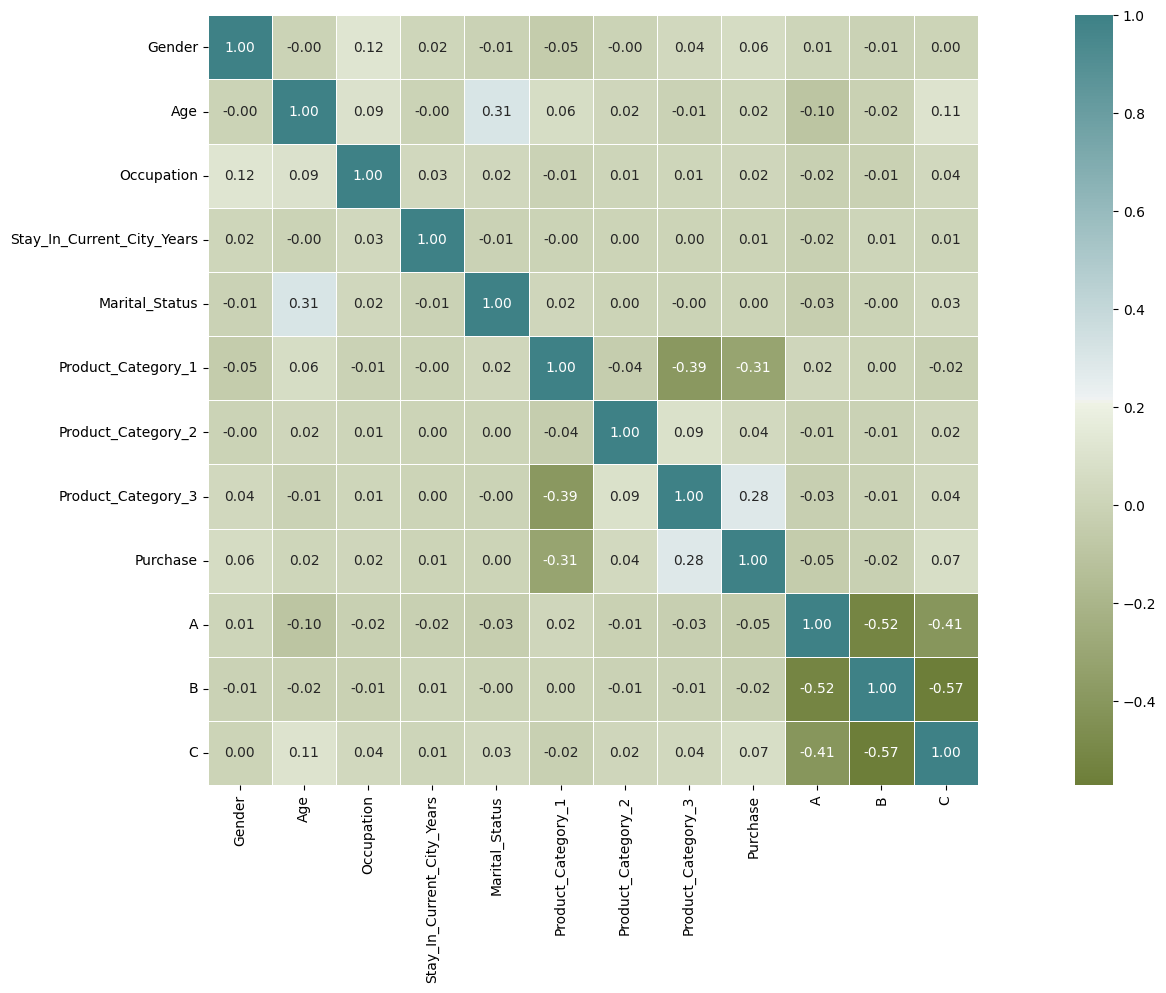

In [54]:
# корреляционный анализ используется для определения степени взаимосвязи между признаками и целевой переменной:
def PrintCorr(dataset):
    plt.figure(figsize=(25,10))
    corr = dataset.corr()
    sns.heatmap(corr,annot=True,linewidths=.5,fmt= '.2f',
                mask=np.zeros_like(corr, dtype=bool),
                cmap=sns.diverging_palette(100,200,as_cmap=True), square=True)
PrintCorr(blackfriday_df)

[Text(0.5, 1.0, 'Корреляция Gender и Purchase')]

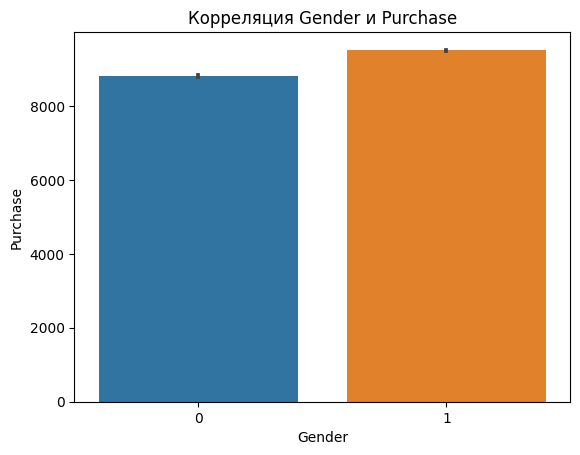

In [55]:
# как влияет Gender на целевую переменную Purchase, построим диаграмму:
sns.barplot(data=blackfriday_df, x='Gender', y='Purchase').set(title='Корреляция Gender и Purchase')

[Text(0.5, 1.0, 'Корреляция Age и Purchase')]

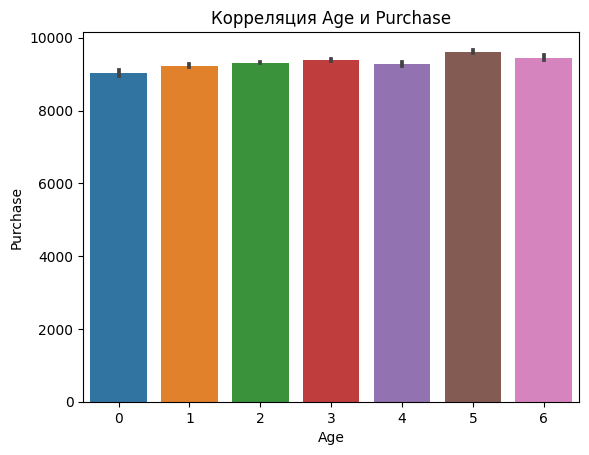

In [56]:
# как влияет Age на целевую переменную Purchase, построим диаграмму:
sns.barplot(data=blackfriday_df, x='Age', y='Purchase').set(title='Корреляция Age и Purchase')

[Text(0.5, 1.0, 'Цена-City_C')]

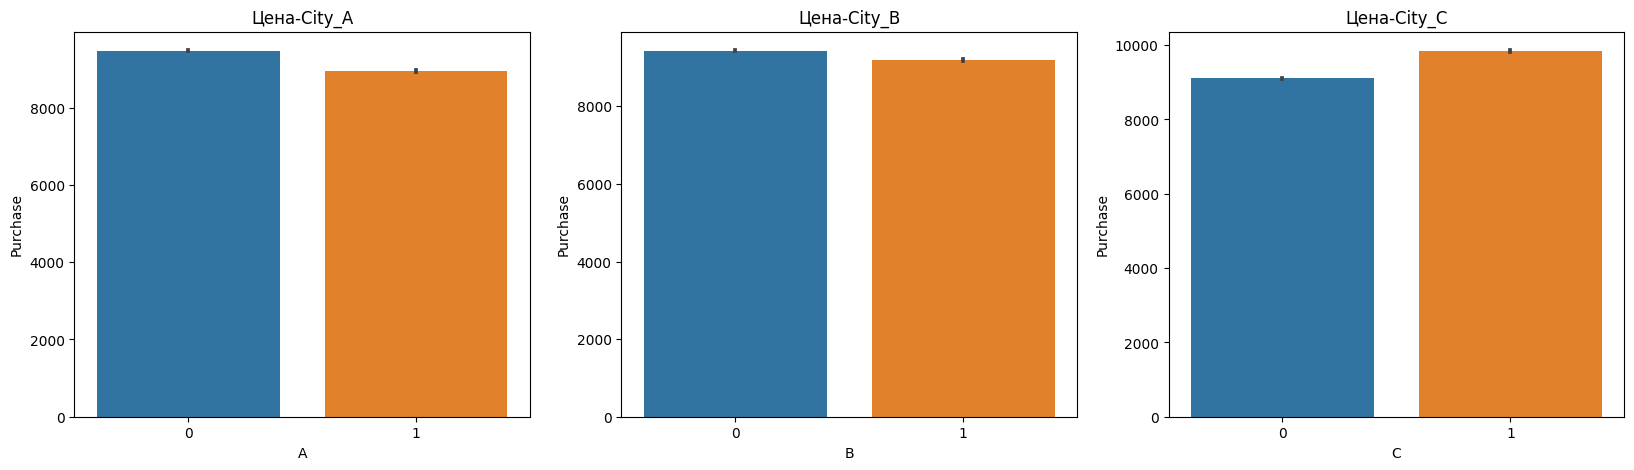

In [57]:
# как влияет City_Category на целевую переменную Purchase, построим диаграмму для каждой закодированной категории:
plt.figure(figsize = (20,5))
plt.subplot(1, 3, 1)
sns.barplot(data=blackfriday_df, x='A', y='Purchase').set(title='Цена-City_A')

plt.subplot(1, 3, 2)
sns.barplot(data=blackfriday_df, x='B', y='Purchase').set(title='Цена-City_B')

plt.subplot(1, 3, 3)
sns.barplot(data=blackfriday_df, x='C', y='Purchase').set(title='Цена-City_C')

# **Model:**

## 6. Построение модели

Масштабирование признаков (Стандартизация):

In [58]:
# Применим к нашим данным масштабирование для того, чтобы модель лучше училась, иначе могут возникнуть проблемы с коэффициентами:
# если какой-то признак принимает очень большие значения, а другой - маленькие, модели будет сложно корректно подобрать веса.

X = blackfriday_df.drop(columns=['Purchase']).copy()
y = blackfriday_df['Purchase']

Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.2, random_state=111)

scaler = StandardScaler().fit(Xtrain) #Стандартизация
Xtrain = scaler.transform(Xtrain)
Xtest = scaler.transform(Xtest)

regressor = LinearRegression()
regressor.fit(Xtrain, ytrain)

ypred_train = regressor.predict(Xtrain)
ypred_test = regressor.predict(Xtest)

In [59]:
r2_score(ytrain,ypred_train), r2_score(ytest,ypred_test)
coefficients = pd.concat([pd.DataFrame(X.columns),pd.DataFrame(np.transpose(regressor.coef_))], axis = 1)
coefficients

,0,0
0,Gender,2.133499e+02
1,Age,1.260221e+02
2,Occupation,3.840685e+01
3,Stay_In_Current_City_Years,1.208649e+01
4,Marital_Status,-1.923976e+01
5,Product_Category_1,-1.194714e+03
6,Product_Category_2,5.589515e+01
7,Product_Category_3,9.250981e+02
8,A,1.363367e+16
9,B,1.518735e+16


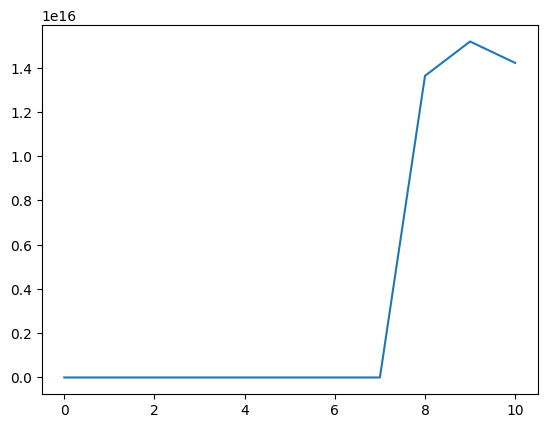

In [60]:
plt.plot(regressor.coef_)

Добавим L1 регуляризацию:

In [61]:
regressor2 = Lasso(alpha=10)
regressor2.fit(Xtrain, ytrain)

ypred2 = regressor2.predict(Xtest)

print('Scores:', r2_score(ytest,ypred2), mean_squared_error(ytest,ypred2))
print(regressor2.coef_,'\n')

Scores: 0.13492380960351558 21525267.35692681
[  201.45395114   121.86008394    31.44344994     4.66624106
    -7.03606186 -1186.88688416    43.6361855    920.39853793
   -57.51263316    -0.           239.34641243] 



In [62]:
# Посмотрим, что происходит при разных значениях параметра регуляризации:
for a in np.arange(0.1,100.2,25):
    regressor2 = Lasso(alpha=a)
    regressor2.fit(Xtrain, ytrain)

    ypred2 = regressor2.predict(Xtest)

    print('alpha={}'.format(a))
    print('Scores:', r2_score(ytest,ypred2), mean_squared_error(ytest,ypred2))
    print(regressor2.coef_,'\n')

alpha=0.1
Scores: 0.13494738179098587 21524680.821725495
[  209.79166474   134.68945557    38.76806793    13.87268116
   -21.18265405 -1194.03924529    52.23897436   925.99364947
  -216.73729641  -170.47598645    85.35117323] 

alpha=25.1
Scores: 0.13480786848880688 21528152.26292638
[  188.50811743   106.92494212    19.97494348     0.
    -0.         -1175.99793213    30.43017283   911.83199471
   -48.01844206    -0.           230.76400322] 

alpha=50.1
Scores: 0.1344086702715469 21538085.31674329
[ 1.66888373e+02  8.59178297e+01  7.44617695e-01  0.00000000e+00
 -0.00000000e+00 -1.15798073e+03  8.49709163e+00  8.97627258e+02
 -3.21491481e+01 -0.00000000e+00  2.16556378e+02] 

alpha=75.1
Scores: 0.1338293635832145 21552499.921475727
[  143.18124984    62.97678482     0.             0.
     0.         -1139.73898569     0.           882.15849546
   -16.16999624    -0.           201.72695779] 

alpha=100.1
Scores: 0.1330529752330274 21571818.4127209
[ 1.19430577e+02  3.97988421e+01  0.00

In [63]:
# Видим, что L1-регуляризация зануляет некоторые веса и таким образом производит отбор признаков.
# Подберем оптимальное значение параметра регуляризации по кросс-валидаци:

from sklearn.linear_model import LassoCV

n_alphas = 200
alphas = np.linspace(0.1, 10.2, n_alphas)

lasso_cv = LassoCV(alphas=alphas,
                   cv=3, random_state=17)
lasso_cv.fit(X, y)

LassoCV(alphas=array([ 0.1       ,  0.15075377,  0.20150754,  0.25226131,  0.30301508,
        0.35376884,  0.40452261,  0.45527638,  0.50603015,  0.55678392,
        0.60753769,  0.65829146,  0.70904523,  0.75979899,  0.81055276,
        0.86130653,  0.9120603 ,  0.96281407,  1.01356784,  1.06432161,
        1.11507538,  1.16582915,  1.21658291,  1.26733668,  1.31809045,
        1.36884422,  1.41959799,  1.47035176,  1.52110553,  1.5718593 ,
        1.62261...
        8.47437186,  8.52512563,  8.5758794 ,  8.62663317,  8.67738693,
        8.7281407 ,  8.77889447,  8.82964824,  8.88040201,  8.93115578,
        8.98190955,  9.03266332,  9.08341709,  9.13417085,  9.18492462,
        9.23567839,  9.28643216,  9.33718593,  9.3879397 ,  9.43869347,
        9.48944724,  9.54020101,  9.59095477,  9.64170854,  9.69246231,
        9.74321608,  9.79396985,  9.84472362,  9.89547739,  9.94623116,
        9.99698492, 10.04773869, 10.09849246, 10.14924623, 10.2       ]),
        cv=3, random_state=17)

In [64]:
lasso_cv.coef_

array([ 482.17884173,  103.48247372,    5.6977877 ,    9.5209288 ,
        -47.30950547, -317.88728808,    8.13645587,  148.34907592,
       -177.5466592 ,  -30.6164984 ,  484.05862112])

In [65]:
lasso_cv.alpha_

0.1

Обучим модель с найденным параметром регуляризации:

In [68]:
regressor2 = Lasso(alpha=lasso_cv.alpha_)

regressor2.fit(Xtrain, ytrain)

ypred2_train = regressor2.predict(Xtrain)
ypred2_test = regressor2.predict(Xtest)

print('Scores:', r2_score(ytrain,ypred2_train), r2_score(ytest,ypred2_test))

Scores: 0.13583617968255368 0.13494738179098587


Добавим L2 регуляризацию:

In [69]:
from sklearn.linear_model import Ridge

for a in np.arange(0,10.1,2.5):
    regressor3 = Ridge(alpha=a)
    regressor3.fit(Xtrain, ytrain)

    ypred3 = regressor3.predict(Xtest)

    print('alpha={}'.format(a))
    print('Scores:',r2_score(ytest,ypred3), mean_squared_error(ytest,ypred3))
    print(regressor3.coef_)

alpha=0.0
Scores: 0.1349165847134124 21525447.13033038
[ 2.13349904e+02  1.22382634e+02  3.82774246e+01  1.62487890e+01
 -1.79852925e+01 -1.19182435e+03  5.41828536e+01  9.26731727e+02
  1.36336652e+16  1.51873453e+16  1.42175818e+16]
alpha=2.5
Scores: 0.13494723217868987 21524684.544455014
[  209.87512751   134.82001117    38.84251072    13.96720651
   -21.32482236 -1194.10318554    52.32569734   926.04912232
  -121.3225824    -64.2045777    184.92375117]
alpha=5.0
Scores: 0.1349472302152559 21524684.59331018
[  209.87427689   134.81879018    38.84259425    13.96715889
   -21.32442856 -1194.09743532    52.32595851   926.04600369
  -121.32228643   -64.20438448   184.92326092]
alpha=7.5
Scores: 0.13494722824708938 21524684.642283108
[  209.87342629   134.81756922    38.84267778    13.96711127
   -21.32403476 -1194.09168517    52.32621968   926.04288507
  -121.32199045   -64.20419126   184.92277067]
alpha=10.0
Scores: 0.13494722627419098 21524684.69137377
[  209.87257568   134.81634829  

In [70]:
# Ridge регрессия не зануляет веса (они могут быть очень маленькими, но ненулевыми).
# Теперь подберем оптимальное aльфа по кросс-валидации:
from sklearn.linear_model import RidgeCV

n_alphas = 200
ridge_alphas = np.logspace(-2, 6, n_alphas)

ridge_cv = RidgeCV(alphas=ridge_alphas,
                   scoring='neg_mean_squared_error',
                   cv=3)
ridge_cv.fit(X, y)

RidgeCV(alphas=array([1.00000000e-02, 1.09698580e-02, 1.20337784e-02, 1.32008840e-02,
       1.44811823e-02, 1.58856513e-02, 1.74263339e-02, 1.91164408e-02,
       2.09704640e-02, 2.30043012e-02, 2.52353917e-02, 2.76828663e-02,
       3.03677112e-02, 3.33129479e-02, 3.65438307e-02, 4.00880633e-02,
       4.39760361e-02, 4.82410870e-02, 5.29197874e-02, 5.80522552e-02,
       6.36824994e-02, 6.98587975e-0...
       1.18953407e+05, 1.30490198e+05, 1.43145894e+05, 1.57029012e+05,
       1.72258597e+05, 1.88965234e+05, 2.07292178e+05, 2.27396575e+05,
       2.49450814e+05, 2.73644000e+05, 3.00183581e+05, 3.29297126e+05,
       3.61234270e+05, 3.96268864e+05, 4.34701316e+05, 4.76861170e+05,
       5.23109931e+05, 5.73844165e+05, 6.29498899e+05, 6.90551352e+05,
       7.57525026e+05, 8.30994195e+05, 9.11588830e+05, 1.00000000e+06]),
        cv=3, scoring='neg_mean_squared_error')

In [71]:
ridge_cv.alpha_

289.94228538828753

In [72]:
regressor3 = Lasso(alpha=ridge_cv.alpha_)

regressor3.fit(Xtrain, ytrain)

ypred3_train = regressor3.predict(Xtrain)
ypred3_test = regressor3.predict(Xtest)

print('Scores:', r2_score(ytrain,ypred3_train), r2_score(ytest,ypred3_test))

Scores: 0.12492815323594642 0.12456410982887534


ElasticNet. Добавим одновременно и L1, и L2 регуляризацию

In [73]:
# У ElasticNet два параметра: alpha и l1_ratio. Используйте ElasticNet со значениями параметров alpha и l1_ratio равными 0.5:
from sklearn.linear_model import ElasticNet

In [74]:
for a in np.arange(0,100.1,10):
    regressor4 = ElasticNet(alpha=a)
    regressor4.fit(Xtrain, ytrain)

    ypred4 = regressor4.predict(Xtest)

    print('alpha={}'.format(a))
    print('Scores:', r2_score(ytest,ypred4), mean_squared_error(ytest,ypred4))
    print(regressor4.coef_)

<ipython-input-74-ba5cb2902508>:3: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  regressor4.fit(Xtrain, ytrain)
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.607e+12, tolerance: 1.066e+09 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


alpha=0.0
Scores: 0.13494723413739185 21524684.495717593
[  209.87597813   134.82123217    38.84242718    13.96725414
   -21.32521618 -1194.10893582    52.32543615   926.05224096
  -217.22789913  -171.03904021    84.9117021 ]
alpha=10.0
Scores: 0.05272403931250369 23570604.00106801
[  46.15107682   14.09659925   14.54020969    2.89834707    0.
 -245.29511244   26.39140284  217.63079182  -33.06305888  -16.72275463
   50.59496979]
alpha=20.0
Scores: 0.03113656310269408 24107754.603680797
[  25.55108001    6.97658725    8.05596583    1.24199138    0.
 -136.88454387   15.21897357  122.36454671  -18.57944125   -9.23681073
   28.7103513 ]
alpha=30.0
Scores: 0.02199983457668464 24335099.34680669
[ 17.47832286   4.419996     5.38181698   0.57316735   0.
 -94.75522029  10.4948897   84.91530914 -12.73265636  -6.19579059
  19.85526106]
alpha=40.0
Scores: 0.016967758837810765 24460310.024018742
[ 13.17002303   3.10448423   3.92567362   0.21164267   0.
 -72.34738929   7.89802075  64.90657056  -9.57

Посмотрим на веса, которые присвоила линейная регрессия признакам (regressor.coef_).

In [75]:
from sklearn.linear_model import ElasticNetCV

n_alphas = 200
alphas = np.linspace(0.1, 10.2, n_alphas)

elastic_cv = ElasticNetCV(alphas=alphas,
                   cv=3, random_state=17)
elastic_cv.fit(X, y)

ElasticNetCV(alphas=array([ 0.1       ,  0.15075377,  0.20150754,  0.25226131,  0.30301508,
        0.35376884,  0.40452261,  0.45527638,  0.50603015,  0.55678392,
        0.60753769,  0.65829146,  0.70904523,  0.75979899,  0.81055276,
        0.86130653,  0.9120603 ,  0.96281407,  1.01356784,  1.06432161,
        1.11507538,  1.16582915,  1.21658291,  1.26733668,  1.31809045,
        1.36884422,  1.41959799,  1.47035176,  1.52110553,  1.5718593 ,
        1....
        8.47437186,  8.52512563,  8.5758794 ,  8.62663317,  8.67738693,
        8.7281407 ,  8.77889447,  8.82964824,  8.88040201,  8.93115578,
        8.98190955,  9.03266332,  9.08341709,  9.13417085,  9.18492462,
        9.23567839,  9.28643216,  9.33718593,  9.3879397 ,  9.43869347,
        9.48944724,  9.54020101,  9.59095477,  9.64170854,  9.69246231,
        9.74321608,  9.79396985,  9.84472362,  9.89547739,  9.94623116,
        9.99698492, 10.04773869, 10.09849246, 10.14924623, 10.2       ]),
             cv=3, random_state=17)

In [76]:
elastic_cv.alpha_

0.1

In [78]:
regressor4 = ElasticNet(alpha=elastic_cv.alpha_)

regressor4.fit(Xtrain, ytrain)

ypred4_train = regressor4.predict(Xtrain)
ypred4_test = regressor4.predict(Xtest)

print('Scores:', r2_score(ytrain,ypred4_train), r2_score(ytest,ypred4_test))

Scores: 0.13567119561005958 0.13476766349228675
